### 导入与忽略警告

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from tabulate import tabulate
import missingno as msno
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.imputation import mice
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import pointbiserialr, chi2_contingency

In [38]:
import warnings
warnings.filterwarnings('ignore')

# 一、问题定义

### 1. Business/Research Need and Research Question
Diabetes is a global chronic disease, and its early identification is critical to reducing complications and alleviating the burden on healthcare systems. The central research need is:

- **To build a predictive model that determines whether an individual has diabetes based on demographic, lifestyle, psychosocial, and medical risk factors.**

The research question can be articulated as:  
*Given a set of features including demographic variables (e.g., age, sex, education, income), lifestyle behaviors (e.g., smoking, alcohol use, physical activity, diet), psychosocial health indicators (e.g., mental and physical unhealthy days), medical history (e.g., stroke, heart disease, hypertension, cholesterol), and healthcare access, can we accurately predict whether an individual is diagnosed with diabetes?*

### 2. Task Type
- **Type of task**: Classification (supervised learning)  
- **Target variable**: `Diabetes` (binary: Yes/No)  
- The goal is to classify individuals into diabetic or non-diabetic categories based on the input features.

### 3. Stakeholders
1. **Public Health Agencies**: Use the model to identify high-risk groups, guide resource allocation, and design preventive strategies.  
2. **Clinicians**: Support risk assessment and provide early intervention for undiagnosed but high-risk individuals.  
3. **Healthcare Insurers**: Optimize resource distribution and cost management through risk stratification.  
4. **Patients and the General Public**: Improve awareness of risk factors, encourage healthier lifestyle changes, and promote self-management.  
5. **Researchers**: Explore the multidimensional determinants of diabetes and contribute to precision medicine studies.

### 4. Value and Benefits
- **Early Detection and Prevention**: Enable identification of undiagnosed individuals at high risk of diabetes for timely intervention.  
- **Reduced Healthcare Burden**: Minimize long-term complications (e.g., cardiovascular disease, stroke) and associated costs through prevention.  
- **Decision Support for Health Management**: Provide evidence for healthcare providers and policymakers to design targeted health education and intervention programs.  
- **Equity in Healthcare**: Address disparities by incorporating socioeconomic variables (education, income), highlighting gaps in access to care.  
- **Scientific Contribution**: Advance research in chronic disease prediction with multidimensional health data modeling.

# 二、数据描述

### 1、读取数据集、数据格式转换、特征与标签分离

In [39]:
# 读取数据集
df = pd.read_csv('diabetes_diagnosis.csv')

# 清理 Unnamed: 0 列：如果存在则删除
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 清理 Income 列：去除美元符号、空字符串，转换为数值
if 'Income' in df.columns:
    df['Income'] = df['Income'].replace('[\$,]', '', regex=True).replace('', np.nan)
    df['Income'] = pd.to_numeric(df['Income'], errors='coerce')

# 去掉 Diabetes 列为空的样本
df = df.dropna(subset=['Diabetes'])

# Diabetes列是标签，其他是特征，分离特征和标签
X = df.drop(columns=['Diabetes'])
y = df['Diabetes']

# 将 y 映射为 0/1 （No -> 0, Diabetes -> 1）
y = y.map({'No': 0, 'Diabetes': 1, 'Prediabetes': 2})

# 检查映射是否成功
print("\n=== Label Mapping Check ===")
print(y.value_counts(dropna=False))


=== Label Mapping Check ===
Diabetes
0    205133
1     34026
2      4459
Name: count, dtype: int64


### 2、统计样本数、特征数、特征类型

In [40]:
# ========== Step 1: 基础信息 & 特征类型统计 ==========
num_samples, num_features = X.shape
print(f"样本数: {num_samples}")
print(f"特征数: {num_features}")

feature_types = {}
categorical_features = []
numeric_features = []

for col in X.columns:
    nunique = X[col].nunique(dropna=False)
    if X[col].dtype == 'object' or nunique < 20:
        feature_types[col] = 'categorical'
        categorical_features.append(col)
    else:
        feature_types[col] = 'numeric'
        numeric_features.append(col)

# 构建表格
feature_type_df = pd.DataFrame({
    'Feature': list(feature_types.keys()),
    'Type': list(feature_types.values())
})

print("\n=== Feature Type Summary ===")
print(tabulate(feature_type_df, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))

print("\nCategorical features:", categorical_features)
print("Numeric features:", numeric_features)

样本数: 243618
特征数: 21

=== Feature Type Summary ===
+----------------------+-------------+
|       Feature        |    Type     |
+======================+=============+
|      CholCheck       | categorical |
+----------------------+-------------+
|         BMI          |   numeric   |
+----------------------+-------------+
|        Smoker        | categorical |
+----------------------+-------------+
|        Stroke        | categorical |
+----------------------+-------------+
| HeartDiseaseorAttack | categorical |
+----------------------+-------------+
|     PhysActivity     | categorical |
+----------------------+-------------+
|        Fruits        | categorical |
+----------------------+-------------+
|       Veggies        | categorical |
+----------------------+-------------+
|    AnyHealthcare     | categorical |
+----------------------+-------------+
|     NoDocbcCost      | categorical |
+----------------------+-------------+
|    GeneralHealth     | categorical |
+-------------

### 3、缺失情况

Total missing values: 2153608


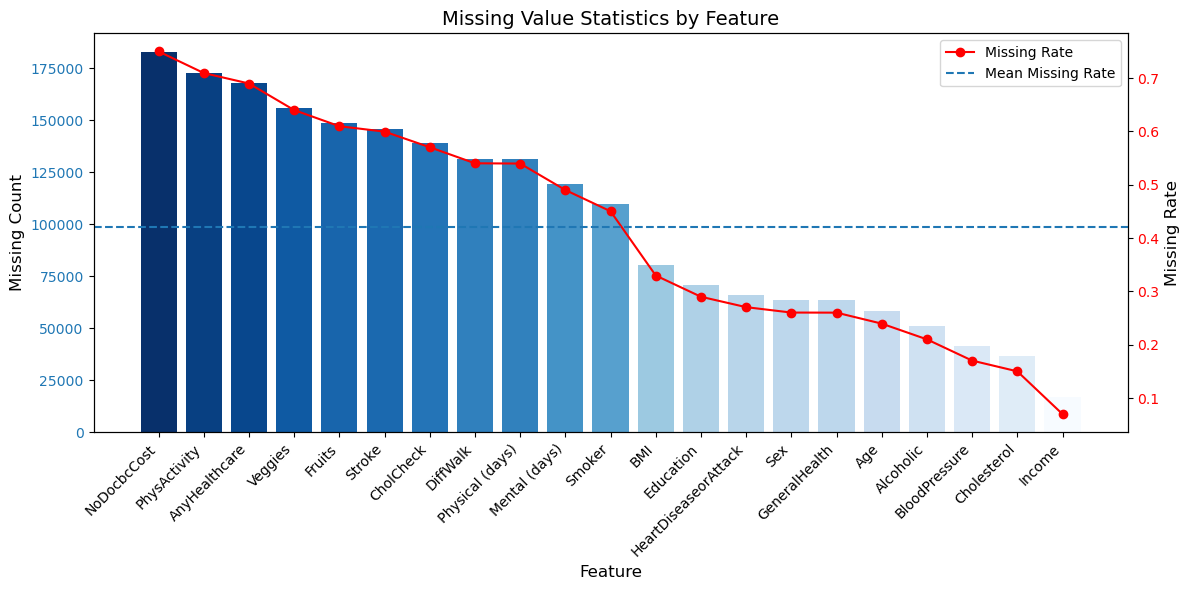

In [41]:
# Calculate total missing values in features only
total_missing = X.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

# Calculate missing count and rate for each feature
missing_count = X.isnull().sum()
missing_rate = missing_count / len(X)

# Combine into DataFrame and sort by missing rate
missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'missing_rate': missing_rate
}).sort_values('missing_rate', ascending=False)

# Mean missing rate
mean_missing_rate = missing_rate.mean()

# Normalize missing_count for color mapping
norm = plt.Normalize(missing_df['missing_count'].min(), missing_df['missing_count'].max())
colors = plt.cm.Blues(norm(missing_df['missing_count']))

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot: missing count with gradient color
bars = ax1.bar(
    missing_df.index, 
    missing_df['missing_count'], 
    color=colors
)
ax1.set_ylabel('Missing Count', fontsize=12)
ax1.set_xlabel('Feature', fontsize=12)
ax1.set_xticklabels(missing_df.index, rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Line plot: missing rate
ax2 = ax1.twinx()
ax2.plot(
    missing_df.index, 
    missing_df['missing_rate'], 
    color='red', 
    marker='o', 
    label='Missing Rate'
)
ax2.set_ylabel('Missing Rate', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Mean missing rate line
ax2.axhline(mean_missing_rate, linestyle='--', label='Mean Missing Rate')

# Legend and title
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='upper right')
plt.title('Missing Value Statistics by Feature', fontsize=14)
plt.tight_layout()
plt.show()

### 4、分类特征唯一值分布

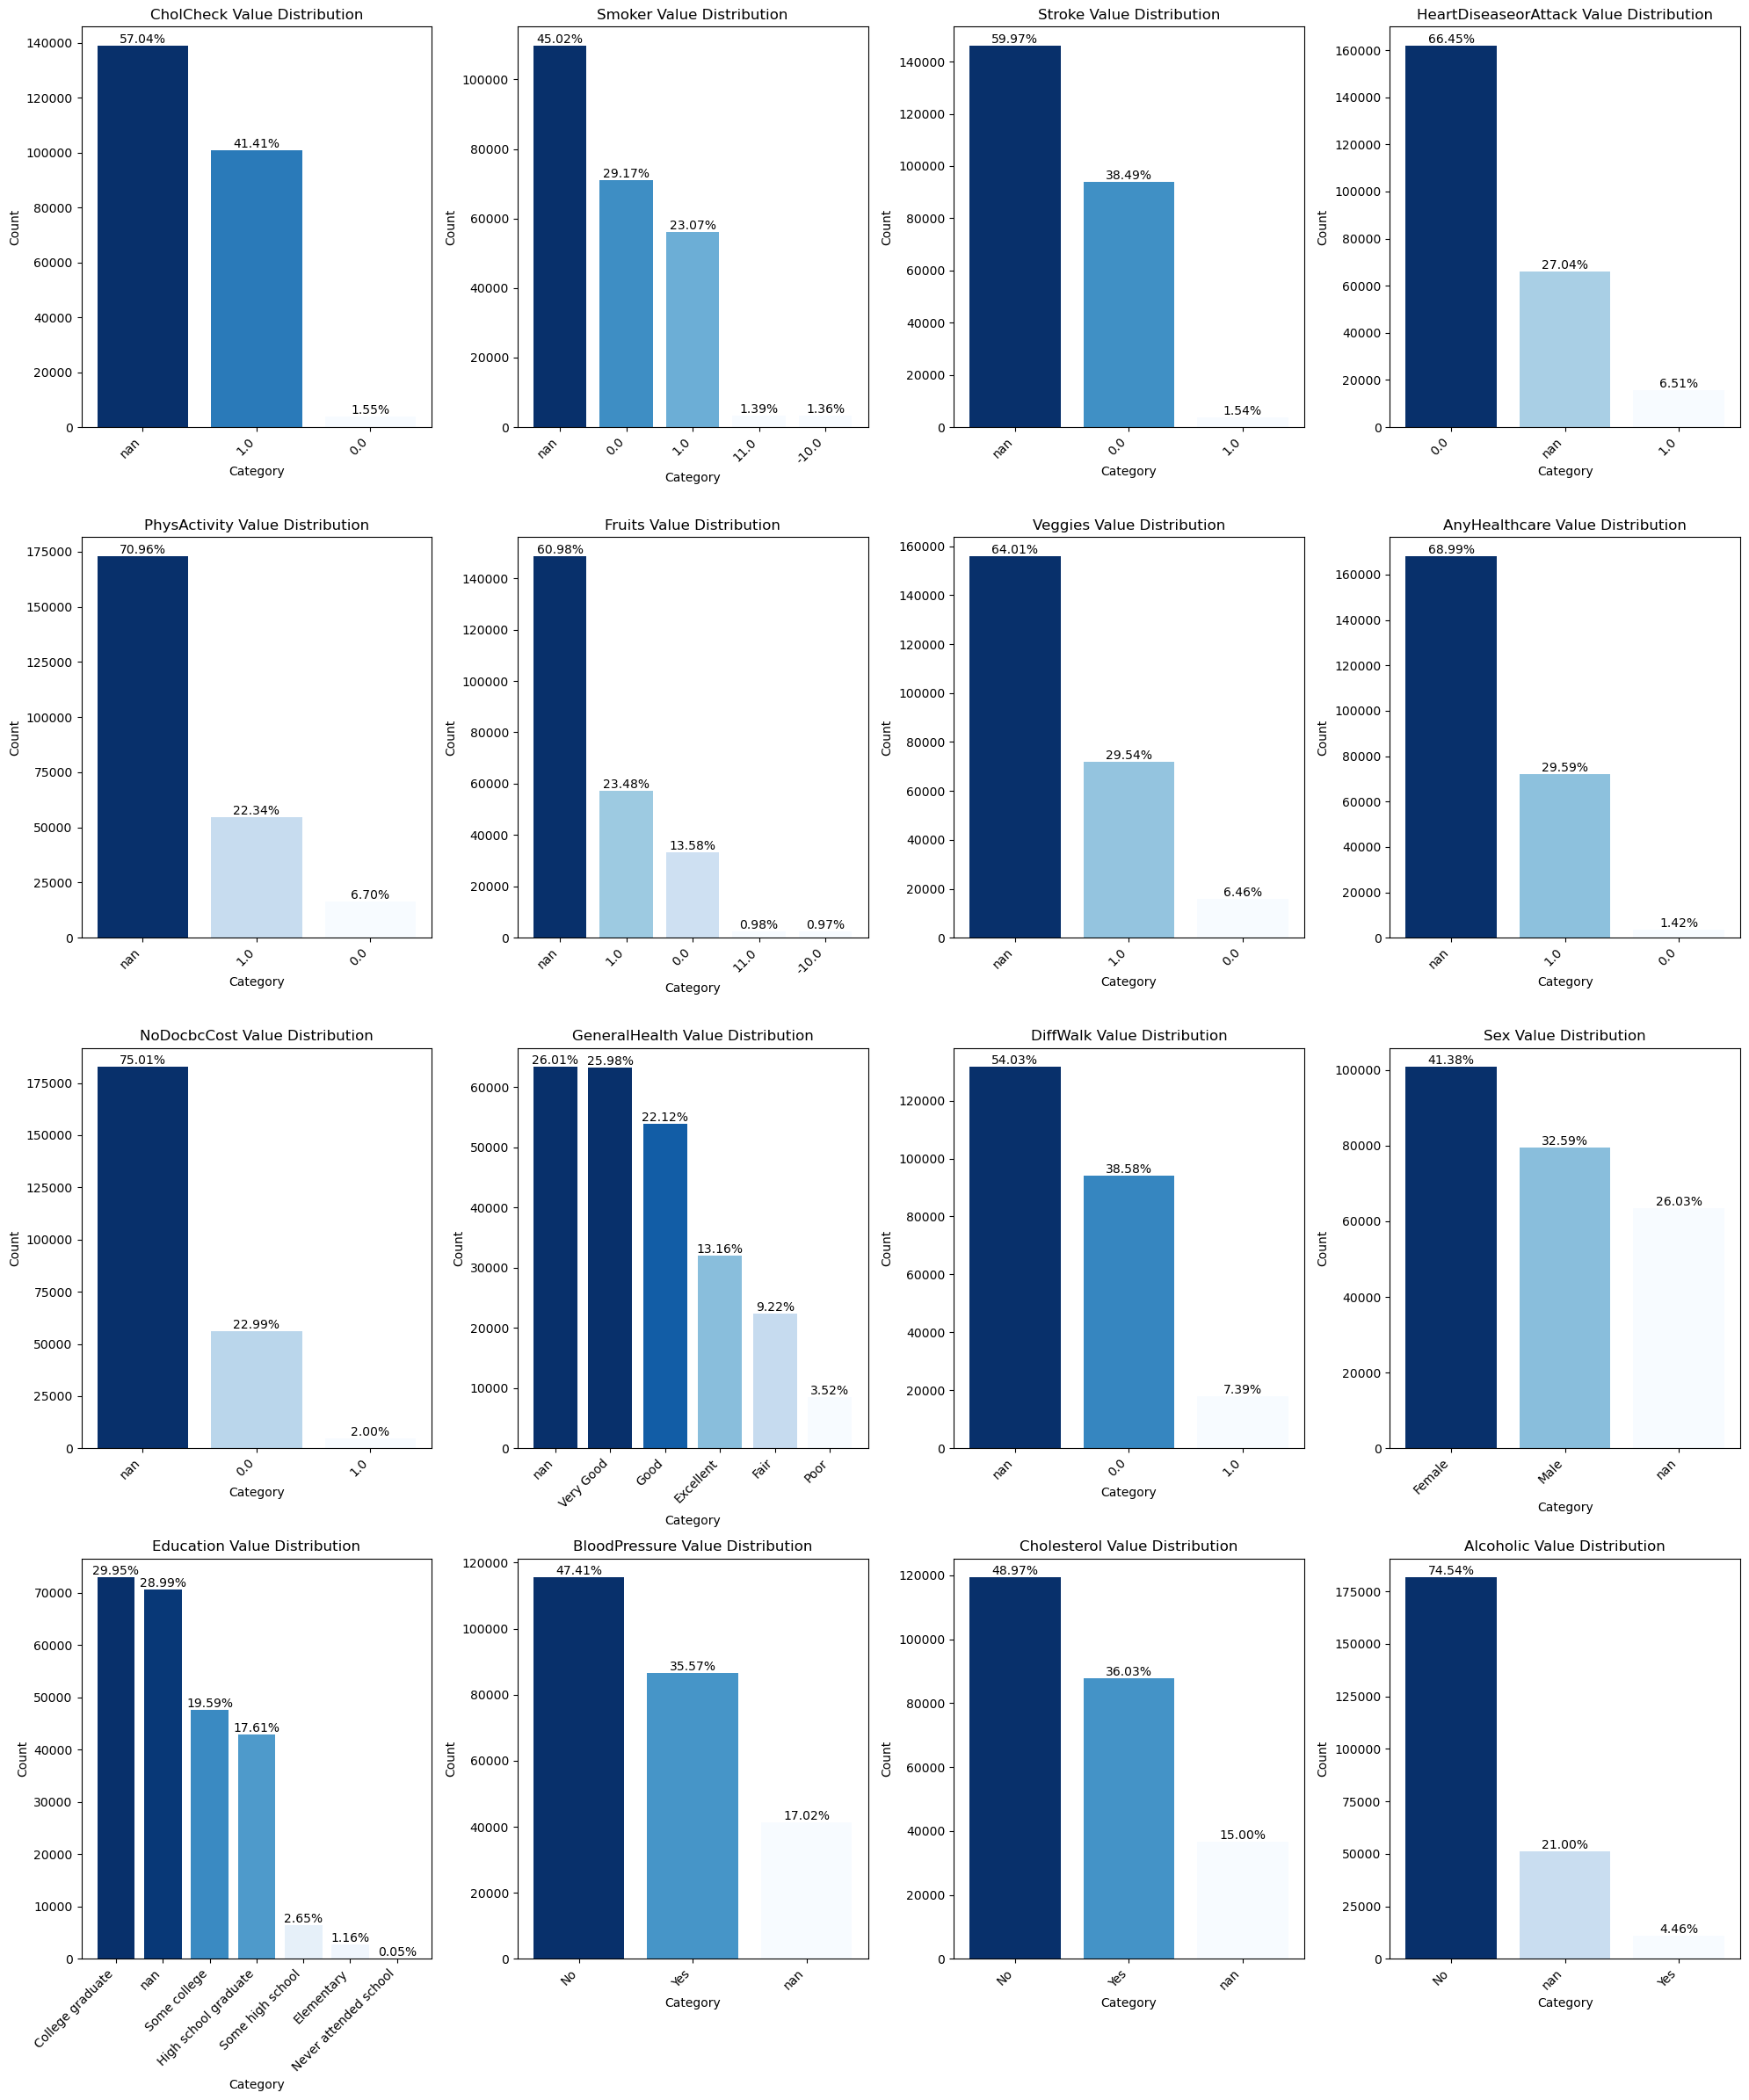

In [42]:
plt.rcParams.update({'font.size': 10})

# 计算 n_cols 和 n_rows
n_cols = 4  # 每行显示 5 个子图
n_rows = len(categorical_features) // n_cols + (1 if len(categorical_features) % n_cols > 0 else 0)  # 计算所需的行数

# 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    value_counts = X[col].value_counts(dropna=False)
    value_props = value_counts / value_counts.sum()
    # 归一化当前特征的数量用于颜色映射
    norm = plt.Normalize(value_counts.min(), value_counts.max())
    bar_colors = cm.Blues(norm(value_counts.values))
    bars = axes[i].bar(value_counts.index.astype(str), value_counts.values, color=bar_colors)
    axes[i].set_title(f'{col} Value Distribution')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    for label in axes[i].get_xticklabels():
        label.set_ha('right')
    for bar, prop in zip(bars, value_props):
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{prop:.2%}',
            ha='center',
            va='bottom'
        )

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# 三、数据清洗与处理

### 1、缺失值处理

首先通过缺失矩阵可视化观察缺失的分布情况，检查看是否集中在某些变量/个体

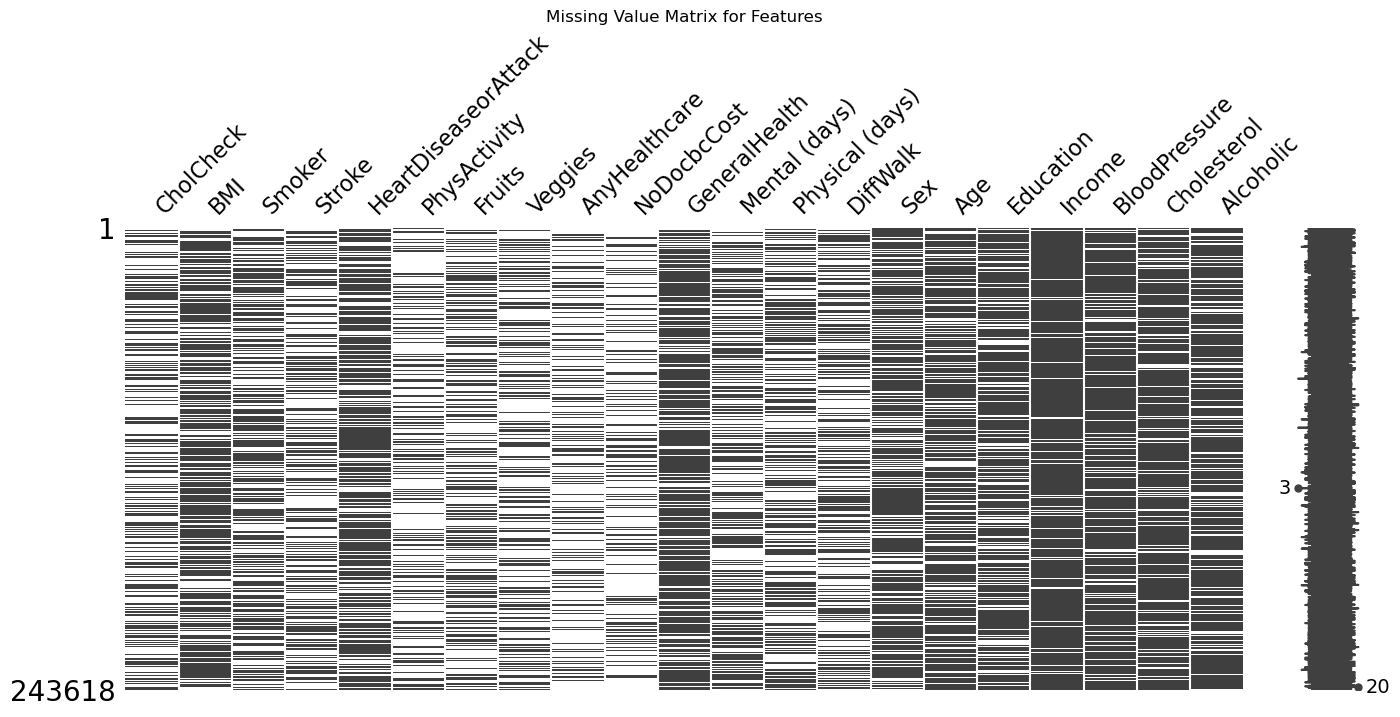

In [43]:
import missingno as msno

# 对特征集 X 进行缺失矩阵可视化，观察缺失值的分布和聚集情况
msno.matrix(X, figsize=(16, 6), sparkline=True)
plt.title("Missing Value Matrix for Features")
plt.show()

然后通过线性回归法检测MAR

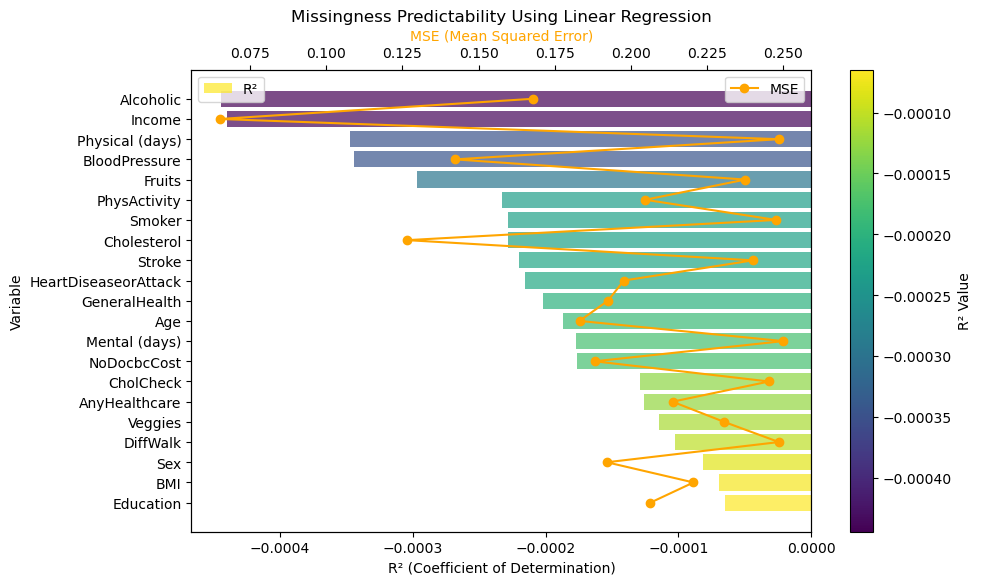

In [44]:
# 1. 构建缺失指示变量
def create_missing_indicators(X):
    return X.isnull().astype(int)

# 2. 用线性回归模型处理缺失情况（适用于数值型和分类变量）
def handle_missingness_with_linear_regression(X):
    missing_indicator = create_missing_indicators(X)
    predictability_scores = []

    for col in X.columns:
        # 构造缺失指示变量，目标是预测缺失情况（1=缺失，0=非缺失）
        indicator = missing_indicator[col]
        
        # 剔除当前特征，选择其余特征进行训练
        other_vars = X.drop(columns=[col]).copy()  # 为避免修改原数据，创建副本
        
        # 对分类变量进行 One-Hot 编码
        if other_vars.select_dtypes(include=['object']).shape[1] > 0:
            other_vars = pd.get_dummies(other_vars, drop_first=True)
        
        # 填补缺失值以便进行训练
        other_vars = other_vars.fillna(other_vars.mean())  # 使用均值填补
        
        X_train, X_test, y_train, y_test = train_test_split(other_vars, indicator, test_size=0.3, random_state=42)

        # 线性回归模型
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # 预测结果
        y_pred = model.predict(X_test)
        
        # 评估模型：使用 R² 和均方误差（MSE）
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # 存储结果
        predictability_scores.append((col, r2, mse))

    return pd.DataFrame(predictability_scores, columns=['Variable', 'R²', 'MSE'])

# 3. 计算并可视化缺失预测能力
predictability_df = handle_missingness_with_linear_regression(X)

# 排序并可视化
predictability_df = predictability_df.sort_values(by='R²', ascending=False)

# 双轴可视化
fig, ax1 = plt.subplots(figsize=(10, 6))

# 选择渐变色（colormap）
norm = plt.Normalize(vmin=predictability_df['R²'].min(), vmax=predictability_df['R²'].max())
cmap = plt.get_cmap('viridis')  # 使用“viridis”渐变色，可以换成其他渐变色

# 绘制 R²（渐变柱状图）
bars = ax1.barh(predictability_df['Variable'], predictability_df['R²'], color=cmap(norm(predictability_df['R²'])), label='R²', alpha=0.7)
ax1.set_xlabel('R² (Coefficient of Determination)')
ax1.set_ylabel('Variable')
ax1.set_title('Missingness Predictability Using Linear Regression')

# 创建第二个轴
ax2 = ax1.twiny()

# 绘制 MSE
ax2.plot(predictability_df['MSE'], predictability_df['Variable'], color='orange', marker='o', label='MSE')
ax2.set_xlabel('MSE (Mean Squared Error)', color='orange')

# 添加渐变色条
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax1)
cbar.set_label('R² Value')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

线性回归结果可以证明缺失模式不是MAR。通过聚类热图进一步检查不同变量的缺失是否存在关联模式

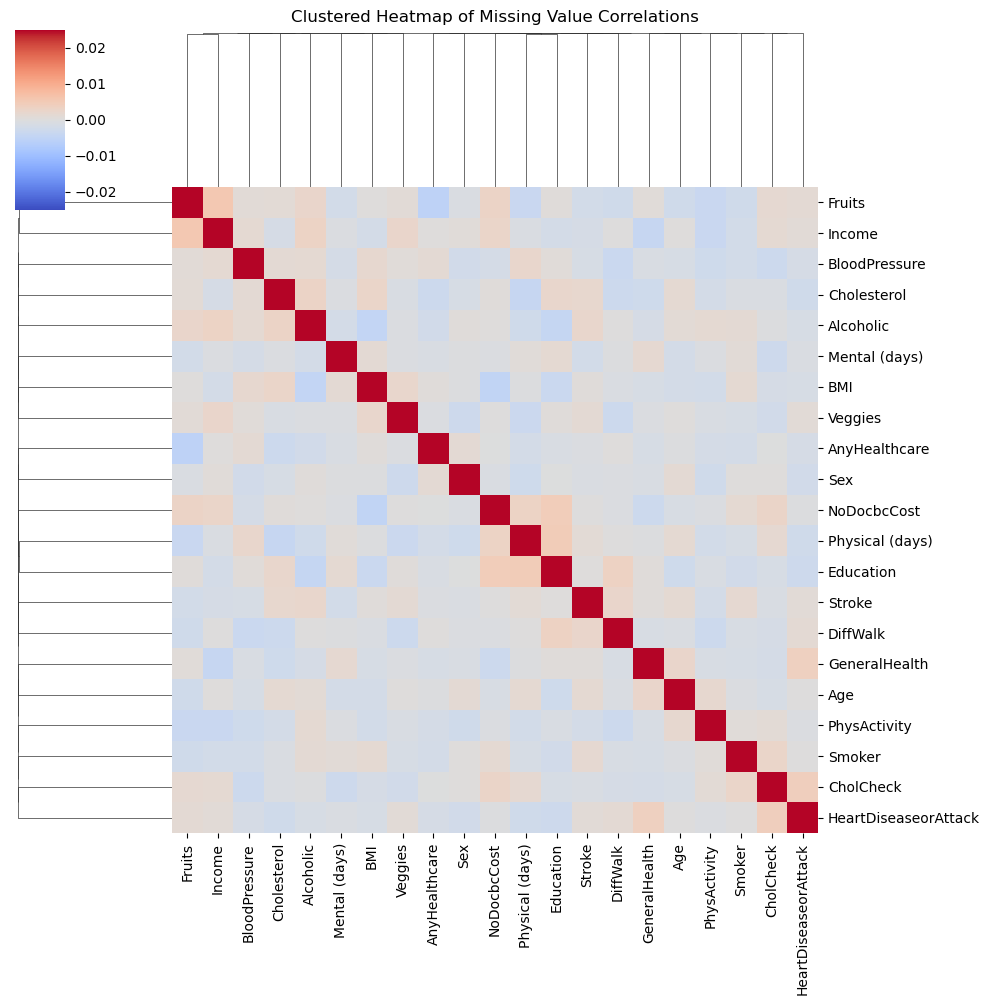

In [45]:
# 生成缺失矩阵 (1=缺失, 0=非缺失)
missing_matrix = X.isnull().astype(int)

# 计算缺失模式的相关性矩阵
corr_matrix = missing_matrix.corr()

# 选择相关性显示的范围
vmin = -0.025 # 根据数据调整
vmax = 0.025 # 根据数据调整

# 绘制聚类热图
sns.clustermap(corr_matrix,
               method="average",   # 层次聚类方法: average, single, complete 等
               metric="euclidean", # 距离度量: euclidean, cosine 等
               cmap="coolwarm",    # 热图配色
               vmin=vmin, vmax=vmax,  # 调整显示的相关性范围
               figsize=(10, 10))

plt.suptitle("Clustered Heatmap of Missing Value Correlations", y=1)
plt.show()

通过聚类热图可以证明缺失模式符合 MCAR。根据一些统计学常用的经验阈值作出如下处理方案的区分：
- <5% → 可忽略，常用单值插补或直接删除无大碍。
- 5–20% → 可接受，需使用合理插补（避免删除过多样本）。
- 20–40% → 风险较大，需稳健插补方法，避免样本量锐减。
- 40–60% → 严重缺失，必须权衡是否保留变量（插补误差可能很大）。
- \>60% → 通常建议删除变量，除非该变量在临床或理论上极为关键。

In [46]:
# 定义分组函数
def categorize_missing(rate):
    if rate < 0.05:
        return "<5% (Negligible)"
    elif rate < 0.20:
        return "5–20% (Acceptable)"
    elif rate < 0.40:
        return "20–40% (Moderate risk)"
    elif rate < 0.60:
        return "40–60% (Serious missing)"
    else:
        return ">60% (Usually remove)"

missing_category = missing_rate.apply(categorize_missing)

# 单个特征缺失表
missing_df = pd.DataFrame({
    "Feature": X.columns,
    "MissingCount": missing_count.values,
    "MissingRate": (missing_rate.values * 100).round(2).astype(str) + "%",
    "Category": missing_category.values
}).sort_values("MissingCount", ascending=False)

print("\n=== Missing Summary (per feature) ===")
print(tabulate(missing_df, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))


=== Missing Summary (per feature) ===
+----------------------+----------------+---------------+--------------------------+
|       Feature        |  MissingCount  |  MissingRate  |         Category         |
+======================+================+===============+==========================+
|     NoDocbcCost      |     182728     |    75.01%     |  >60% (Usually remove)   |
+----------------------+----------------+---------------+--------------------------+
|     PhysActivity     |     172866     |    70.96%     |  >60% (Usually remove)   |
+----------------------+----------------+---------------+--------------------------+
|    AnyHealthcare     |     168079     |    68.99%     |  >60% (Usually remove)   |
+----------------------+----------------+---------------+--------------------------+
|       Veggies        |     155931     |    64.01%     |  >60% (Usually remove)   |
+----------------------+----------------+---------------+--------------------------+
|        Fruits        |  

In [47]:
category_stats = missing_df.groupby("Category").agg(
    FeatureCount=("Feature", "count"),
    Features=("Feature", lambda x: list(x))
).reset_index()

category_stats["Proportion"] = (category_stats["FeatureCount"] / len(X.columns) * 100).round(2).astype(str) + "%"

print("\n=== Missing Summary by Category ===")
print(tabulate(category_stats, headers='keys', tablefmt='grid', showindex=False, stralign='center', numalign='center'))


=== Missing Summary by Category ===
+--------------------------+----------------+------------------------------------------------------------------------------------------+--------------+
|         Category         |  FeatureCount  |                                         Features                                         |  Proportion  |
+==========================+================+==========================================================================================+==============+
|  20–40% (Moderate risk)  |       7        | ['BMI', 'Education', 'HeartDiseaseorAttack', 'Sex', 'GeneralHealth', 'Age', 'Alcoholic'] |    33.33%    |
+--------------------------+----------------+------------------------------------------------------------------------------------------+--------------+
| 40–60% (Serious missing) |       6        |    ['Stroke', 'CholCheck', 'DiffWalk', 'Physical (days)', 'Mental (days)', 'Smoker']     |    28.57%    |
+--------------------------+----------------+------

In [48]:
category_stats

,Category,FeatureCount,Features,Proportion
0,20–40% (Moderate risk),7,"[BMI, Education, HeartDiseaseorAttack, Sex, Ge...",33.33%
1,40–60% (Serious missing),6,"[Stroke, CholCheck, DiffWalk, Physical (days),...",28.57%
2,5–20% (Acceptable),3,"[BloodPressure, Cholesterol, Income]",14.29%
3,>60% (Usually remove),5,"[NoDocbcCost, PhysActivity, AnyHealthcare, Veg...",23.81%


## Missing–Information Tradeoff 分析说明

针对 40–60% 缺失率（Serious Missing）和 >60% 缺失率（Usually Remove）的特征，我们使用经典的信息量与缺失率权衡方法进行评估：

1. **信息量度量 (IV_value)**  
   - **连续变量**：计算 **Point-Biserial Correlation** 与二分类目标（Diabetes）之间的相关系数，并进行显著性检验 (p-value)。  
   - **分类变量**：计算 **Cramér’s V** 与二分类目标的关联强度，并使用 **Chi-Square test** 进行统计显著性检验。  
   - IV_value 用作衡量特征对目标的解释力（信息量）。  

2. **缺失率加权指标 (Score)**  
Score 用于综合特征信息量与缺失率，计算公式如下：
$$
\text{Score} = \text{IV\_value} \times (1 - \text{MissingRate})
$$
   - Score 综合考虑特征的解释力与缺失率。  
   - 缺失率高的特征，即使 IV_value 较大，Score 也会降低，体现信息损失。  

3. **经验阈值**  
   | IV_value | 预测力评估 |
   |----------|------------|
   | < 0.02   | 无预测力   |
   | 0.02–0.1 | 弱预测力   |
   | 0.1–0.3  | 中等预测力 |
   | ≥ 0.3    | 强预测力（需警惕数据泄漏） |

4. **Score 阈值对应保留策略**  
   - **Keep**：Score ≥ 0.1 （特征信息量足够且缺失率可接受）  
   - **Review**：0.02 ≤ Score < 0.1 （特征信息量有限或缺失率较高，需要人工判断）  
   - **Remove**：Score < 0.02 （特征信息量低，缺失率高，可直接舍弃）  

5. **补充说明**  
   - 对 5 个 Usually Remove 特征也进行了相同评估，以判断是否存在隐藏信息值得保留。  
   - p 值用于辅助判断统计显著性，但不直接用于 Score 计算。


In [49]:
def evaluate_high_missing_features(
    X, y,
    min_valid_n=30,
    keep_thres=0.1,
    review_thres=0.02,
    categories_to_eval=None,
    infer_feature_types=True,
    verbose=True
):
    """
    Evaluate features in >60% and 40-60% missing categories.
    Inputs:
      - X: pd.DataFrame (features only)
      - y: pd.Series (binary label, values 0/1 or convertible to numeric)
      - min_valid_n: 最小有效样本数阈值（低于则标记为 insufficient）
      - keep_thres / review_thres: Score 阈值
      - categories_to_eval: if None, default to [">60% (Usually remove)", "40–60% (Serious missing)"]
      - infer_feature_types: 是否自动推断 numeric/categorical（否则需提供外部 dict）
      - verbose: 是否打印详细中间信息
    Returns:
      - category_stats: DataFrame（每个缺失分组与包含的特征）
      - results_df: DataFrame（每个被评估特征的详细指标与Decision）
    """

    # ---------- 0. 对齐并准备 y ----------
    y = y.reindex(X.index)
    y_num = pd.to_numeric(y, errors='coerce')
    if y_num.isnull().any():
        if verbose:
            print("[WARN] y 中存在非数值或缺失值，已转为 NaN；相关性计算将基于非缺失 y。")
    # 检查二分类
    unique_y = pd.Series(y_num.dropna().unique())
    if set(unique_y.tolist()) - {0,1}:
        if verbose:
            print(f"[INFO] y 唯一值（非缺失）示例: {unique_y.tolist()[:10]}. 请确认 y 是二分类（0/1）。")

    # ---------- 1. 计算缺失率并构建 category_stats ----------
    missing_count = X.isnull().sum()
    missing_rate = missing_count / len(X)
    missing_df = pd.DataFrame({
        "Feature": X.columns,
        "MissingCount": missing_count.values,
        "MissingRate": missing_rate.values
    }).sort_values("MissingRate", ascending=False).reset_index(drop=True)
    missing_df["Category"] = missing_df["MissingRate"].apply(categorize_missing)

    # category_stats: FeatureCount, Features(list), Proportion
    category_stats = missing_df.groupby("Category").agg(
        FeatureCount=("Feature", "count"),
        Features=("Feature", lambda x: list(x))
    ).reset_index()
    category_stats["Proportion"] = (category_stats["FeatureCount"] / X.shape[1] * 100).round(2).astype(str) + "%"

    if verbose:
        print("\n=== Missing Summary by Category ===")
        print(tabulate(category_stats, headers="keys", tablefmt="grid", showindex=False))

    # ---------- 2. 选择评估的类别 ----------
    if categories_to_eval is None:
        categories_to_eval = [">60% (Usually remove)", "40–60% (Serious missing)"]

    # 收集要评估的特征
    feats_to_eval = []
    for cat in categories_to_eval:
        row = category_stats[category_stats["Category"] == cat]
        if not row.empty:
            feats_to_eval.extend(row.iloc[0]["Features"])
    feats_to_eval = list(dict.fromkeys(feats_to_eval))  # 去重并保持顺序

    if len(feats_to_eval) == 0:
        print("[INFO] 没有在指定类别中找到特征，检查 category_labels 是否一致。")
        return category_stats, pd.DataFrame()

    if verbose:
        print("\n[INFO] 将评估的特征列表 (categories = {}):".format(categories_to_eval))
        print(feats_to_eval)

    # ---------- 3. 推断 feature_types（若需要） ----------
    if infer_feature_types:
        feature_types = {}
        for col in X.columns:
            nunique = X[col].nunique(dropna=False)
            if X[col].dtype == 'object' or nunique < 20:
                feature_types[col] = 'categorical'
            else:
                feature_types[col] = 'numeric'
    else:
        # 若外部提供 feature_types，请在作用域外先定义
        try:
            feature_types
        except NameError:
            raise ValueError("infer_feature_types=False 时必须提前定义 feature_types dict")

    # ---------- 4. 逐特征评估并打印中间信息 ----------
    records = []
    for feat in feats_to_eval:
        if verbose:
            print("\n" + "="*80)
            print(f"[PROCESS] Feature: {feat}")

        mr = float(missing_rate.loc[feat])  # 0-1
        mc = int(missing_count.loc[feat])
        ftype = feature_types.get(feat, 'numeric')

        # 有效样本索引（X 非缺且 y 非缺）
        valid_idx = X[feat].notnull() & y_num.notnull()
        n_valid = int(valid_idx.sum())
        if verbose:
            print(f" MissingCount = {mc}, MissingRate = {mr*100:.2f}%, ValidN (X non-missing & y non-missing) = {n_valid}")

        # 输出一些数据快照与 unique 汇总（帮助监控）
        sample_unique = None
        try:
            sample_unique = X.loc[valid_idx, feat].drop_duplicates().head(10).tolist()
            if verbose:
                print(f" Sample of up to 10 unique values (non-missing): {sample_unique}")
                print(f" Unique count (non-missing): {X.loc[valid_idx, feat].nunique(dropna=True)}")
        except Exception as e:
            if verbose:
                print(f" [WARN] 无法获取 unique sample: {e}")

        iv_value = np.nan
        stat_p = np.nan
        stat_raw = None

        # 数值型 -> point-biserial correlation
        if ftype == 'numeric':
            if n_valid < min_valid_n:
                if verbose:
                    print(f" [INFO] 有效样本小于 min_valid_n ({min_valid_n})，相关性结果将视为不可靠（标注为 insufficient）。")
            else:
                try:
                    xs = X.loc[valid_idx, feat].astype(float)
                    ys = y_num.loc[valid_idx].astype(float)
                    corr, pval = pointbiserialr(xs, ys)
                    iv_value = abs(float(corr)) if (corr is not None and not np.isnan(corr)) else 0.0
                    stat_p = float(pval) if pval is not None else np.nan
                    stat_raw = {"corr": corr, "pval": pval}
                    if verbose:
                        print(f" point-biserial r = {corr:.6f}, p = {pval:.4g}, IV_value(|r|) = {iv_value:.6f}")
                except Exception as e:
                    iv_value = 0.0
                    if verbose:
                        print(f" [ERROR] 计算 point-biserial 失败: {e}. 将 iv_value 设为 0.")

        # 类别型 -> Chi-square & Cramér's V
        else:
            if n_valid < 2:
                if verbose:
                    print(" [INFO] 有效样本过少，无法构造列联表。")
                iv_value = np.nan
            else:
                try:
                    cont = pd.crosstab(X.loc[valid_idx, feat].astype(str), y_num.loc[valid_idx])
                    if verbose:
                        print(" Contingency table (top-left 10x10 shown if large):")
                        # 打印列联表（若很大，仅显示头尾）
                        print(cont.head(10).iloc[:, :10])
                    if cont.size == 0 or cont.shape[0] <= 1 or cont.shape[1] <= 1:
                        iv_value = 0.0
                        if verbose:
                            print(" [INFO] 列联表维度 <=1，认为无信息 (iv_value=0).")
                    else:
                        chi2, p, dof, expected = chi2_contingency(cont)
                        n = cont.to_numpy().sum()
                        phi2 = chi2 / n if n > 0 else 0.0
                        r, k = cont.shape
                        denom = min(r-1, k-1)
                        cramer_v = np.sqrt(phi2 / denom) if denom > 0 else 0.0
                        iv_value = float(cramer_v)
                        stat_p = float(p)
                        stat_raw = {"chi2": chi2, "p": p, "dof": dof}
                        if verbose:
                            print(f" chi2 = {chi2:.6f}, p = {p:.4g}, Cramér's V = {cramer_v:.6f}")
                except Exception as e:
                    iv_value = 0.0
                    if verbose:
                        print(f" [ERROR] 计算卡方/列联表失败: {e}. 将 iv_value 设为 0.")

        # 若 iv_value 是 NaN（通常是有效样本太少），记录为 NaN 但计算 Score 时按 0 计算以便排序
        iv_numeric = 0.0 if pd.isna(iv_value) else float(iv_value)
        score = iv_numeric * (1.0 - mr)

        # 决策逻辑
        if pd.isna(iv_value):
            decision = "Review (insufficient data)"
        else:
            if score >= keep_thres:
                decision = "Keep"
            elif score >= review_thres:
                decision = "Review"
            else:
                decision = "Remove"

        # 记录详细信息
        rec = {
            "Feature": feat,
            "Type": ftype,
            "MissingCount": mc,
            "MissingRate(%)": round(mr*100, 2),
            "ValidN": n_valid,
            "IV_value": round(iv_numeric, 6),
            "Stat_raw": stat_raw,
            "Stat_p": round(stat_p, 6) if not pd.isna(stat_p) else None,
            "Score": round(score, 6),
            "Decision": decision
        }
        records.append(rec)

    # ---------- 5. 返回与打印结果 ----------
    results_df = pd.DataFrame(records).sort_values("Score", ascending=False).reset_index(drop=True)

    # 打印结果表（简洁版）
    disp = results_df.copy()
    if "Stat_raw" in disp.columns:
        disp = disp.drop(columns=["Stat_raw"])
    print("\n=== Evaluation Summary (concise) ===")
    print(tabulate(disp, headers="keys", tablefmt="grid", showindex=False))

    # 若需要原始详细结果（含 Stat_raw），可以返回 results_df
    return category_stats, results_df

In [50]:
category_stats, results_df = evaluate_high_missing_features(X, y, min_valid_n=30, verbose=True)
# results_df.to_csv("high_missing_evaluation.csv", index=False)

[INFO] y 唯一值（非缺失）示例: [0, 1, 2]. 请确认 y 是二分类（0/1）。

=== Missing Summary by Category ===
+--------------------------+----------------+------------------------------------------------------------------------------------------+--------------+
| Category                 |   FeatureCount | Features                                                                                 | Proportion   |
+==========================+================+==========================================================================================+==============+
| 20–40% (Moderate risk)   |              7 | ['BMI', 'Education', 'HeartDiseaseorAttack', 'Sex', 'GeneralHealth', 'Age', 'Alcoholic'] | 33.33%       |
+--------------------------+----------------+------------------------------------------------------------------------------------------+--------------+
| 40–60% (Serious missing) |              6 | ['Stroke', 'CholCheck', 'DiffWalk', 'Physical (days)', 'Mental (days)', 'Smoker']        | 28.57%       |
+-

可以看到大部份特征都处于review，说明除了统计学与信息方面的考量，还需要更精细化的处理。要纳入预测里显著性、去冗余分配策略、特征理论重要性、数据类型偏好进行进一步比较。因此我建立了一套完善的Missing–Information Tradeoff评价标准

# 特征筛选与加权评分体系

---

本文档提出一套系统化的特征评估与筛选流程，适用于所有特征（不仅仅是高缺失特征）。方案基于统计学、流行病学、信息论与建模理论，形成一个多维度、可解释、可执行的指标体系。



### 1. 总体思路

通过构建一个综合评分（Score），对所有候选特征进行量化评价。评分考虑了特征预测力、缺失率、业务理论价值、多重共线性风险以及数据类型差异，确保既符合统计学原则，又具备领域合理性。

最终评分公式为：

$$
\text{Score} = \text{IV\_value} \times (1 - \text{MissingRate}) \times w_b \times w_t \times w_r
$$

其中：
- **IV_value**：信息值（Information Value），衡量特征区分度  
- **(1 - MissingRate)**：缺失率惩罚因子  
- **w_b**：业务/理论权重  
- **w_t**：类型调整系数  
- **w_r**：冗余折减系数（考虑共线性/相似性）

---

### 2. 组成要素

### 2.1 信息值（IV_value）
- 定义：衡量自变量与因变量之间的区分能力，常用于风险建模。  
- 计算方法：基于 WOE（Weight of Evidence）分箱统计。  
- 理论依据：信息论，IV 越高说明变量对目标分类的解释力越强。  

### 2.2 缺失率惩罚 (1 - MissingRate)
- 含义：缺失越严重，特征可靠性越差。  
- 范围：当 MissingRate = 0 时惩罚为 1；当 MissingRate = 100% 时惩罚为 0。  
- 理论依据：有效样本量影响统计功效（Statistical Power）。

### 2.3 业务/理论权重 (w_b)
按照公共健康与流行病学的重要性分区：
- **一区（核心健康/疾病变量，w_b = 1.2）**  
  - Stroke（中风，直接疾病结局）  
  - PhysActivity（身体活动，主要危险因素）  
- **二区（一般健康行为/风险因子，w_b = 1.0）**  
  - Smoker（吸烟，经典危险因素）  
  - CholCheck（胆固醇检测，风险筛查）  
- **三区（辅助/生活方式变量，w_b = 0.8）**  
  - Physical (days)（身体不适天数，主观指标）  
  - Mental (days)（心理不适天数，主观指标）  
  - Veggies（蔬菜摄入频率，主观偏倚大）

> 理论依据：疾病流行病学分级，核心病因 > 一般风险因子 > 生活方式/主观健康指标。

### 2.4 类型调整系数 (w_t)
- 连续变量：**w_t = 1.0**  
  - 信息熵更高，可捕捉细微差异。  
- 分类型变量：**w_t = 0.9**  
  - 容易受分箱或稀疏分布影响，信息量可能低估或高估。  

> 理论依据：香农熵（Shannon Entropy），连续变量的潜在信息量通常更大。

### 2.5 冗余折减系数 (w_r)
- 基于多重共线性和变量冗余度计算。  
- 方法：
  1. **相关性矩阵（Pearson/Spearman）**：仅基于有效样本重叠子集计算。  
  2. **方差膨胀因子 (VIF)**：若 VIF > 10，说明强多重共线性。  
  3. **处理方式**：
     - 保留 IV 更高、缺失更少的特征；  
     - 对于相似特征，弱者的 **w_r 下调至 [0.3, 0.7]**。  

> 理论依据：共线性会导致估计不稳定，降低模型解释力。对弱变量降权而非直接删除，可避免过度简化。

---

### 3. 整体流程

1. **计算信息值 (IV)**  
   - 对所有变量进行分箱计算，得到 IV_value。  

2. **计算缺失率惩罚**  
   - 直接统计缺失比例，得到 (1 - MissingRate)。  

3. **分配业务/理论权重 (w_b)**  
   - 根据流行病学意义分区。  

4. **分配类型调整系数 (w_t)**  
   - 连续/分类变量分别赋值。  

5. **计算冗余折减系数 (w_r)**  
   - 相关性矩阵 + VIF，若高相关/高 VIF，则弱变量 w_r < 1。  

6. **计算最终 Score**  
   \[
   \text{Score} = \text{IV\_value} \times (1 - \text{MissingRate}) \times w_b \times w_t \times w_r
   \]

7. **排序与筛选**  
   - 按 Score 从高到低排序；  
   - 保留高分变量，低分变量进入复核或剔除列表。  

---

### 4. 理论优势

- **综合性**：同时考虑预测力、缺失率、业务价值、共线性。  
- **可解释性**：每个权重因子都有明确的统计学/流行病学依据。  
- **灵活性**：不同任务可调整 w_b 和 w_t。  
- **稳健性**：冗余折减避免多重共线性导致的偏差。  

In [ ]:
 'PhysActivity',  'Veggies',]        